# Dev - Image retrieval and processing

Scrape the employee list on the website of a former employer, load all the pictures, and process them in a way to make them suitable as training data for an image generating GAN of employee faces.

This notebooks serves as a playground for experimentation and development and for documentation on some learnings made. <br>The final pipline is properly scripted elsewhere.

**Contents**

- Retrieve and load pictures
- Detect faces and crop to uniform size
- Check for differences in handling PIL and OpenCV image formats


**Change-Log**

- 2020-09-23: Start notebook


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dev-&amp;-Experiment" data-toc-modified-id="Dev-&amp;-Experiment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dev &amp; Experiment</a></span><ul class="toc-item"><li><span><a href="#Scrape-employee-fotos" data-toc-modified-id="Scrape-employee-fotos-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Scrape employee fotos</a></span></li><li><span><a href="#Detect-Faces" data-toc-modified-id="Detect-Faces-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Detect Faces</a></span></li><li><span><a href="#Crop-Pictures" data-toc-modified-id="Crop-Pictures-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Crop Pictures</a></span><ul class="toc-item"><li><span><a href="#Crop-and-resize-PIL-images" data-toc-modified-id="Crop-and-resize-PIL-images-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Crop and resize PIL images</a></span></li><li><span><a href="#Crop-and-resize-OpenCV-images" data-toc-modified-id="Crop-and-resize-OpenCV-images-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Crop and resize OpenCV images</a></span></li></ul></li><li><span><a href="#Play-around-with-color-conversions" data-toc-modified-id="Play-around-with-color-conversions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Play around with color conversions</a></span></li></ul></li><li><span><a href="#Perform-some-Tests" data-toc-modified-id="Perform-some-Tests-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Perform some Tests</a></span><ul class="toc-item"><li><span><a href="#Crop-multiple-faces-from-a-picture" data-toc-modified-id="Crop-multiple-faces-from-a-picture-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Crop multiple faces from a picture</a></span></li><li><span><a href="#What-happens-when-no-face-is-detected?" data-toc-modified-id="What-happens-when-no-face-is-detected?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>What happens when no face is detected?</a></span></li></ul></li><li><span><a href="#Test-full-pipe" data-toc-modified-id="Test-full-pipe-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test full pipe</a></span></li></ul></div>

---

In [54]:
import configparser
import json
import sys
from io import BytesIO
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

In [62]:
%load_ext autoreload
%autoreload 2

In [142]:
config_path = Path.cwd().parent / "config.cfg"


config = configparser.ConfigParser()
try:
    config.read(config_path)
except FileNotFoundError as e:
    raise (f"Please check the path to the config file: {e}")


full_url = config.get("SCRAPING", "FULL_URL")
base_url = config.get("SCRAPING", "BASE_URL")
fc_location = config.get("IMG_PROCESS", "FACE_CASCADE_RELPATH")
scale_factor = float(config.get("IMG_PROCESS", "SCALE_FACTOR"))
dsize = tuple(json.loads(config.get("IMG_PROCESS", "DSIZE")))

## Dev & Experiment

### Scrape employee fotos

In [6]:
# Fetch web page content
response = requests.get(full_url)

# Response is in JSON-Format, save to dict
employees = json.loads(response.text)

# Parse dict - get foto source for first employee 
print(employees['modules'][0]['data']['media']['source'])

/media/1079/alr.jpg


In [7]:
# Check how many employees there are
len(employees['modules'])

795

https://implementconsultinggroup.com//media/1079/alr.jpg
(1766, 1179)


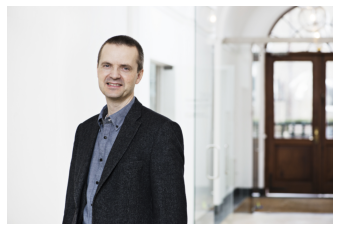

In [97]:
# Load image of first employee, display it and it's size
path_to_pic = employees['modules'][0]['data']['media']['source']
url_to_image = base_url + path_to_pic
print(url_to_image)
r = requests.get(url_to_image)
pil_img = Image.open(BytesIO(r.content))

print(pil_img.size)
plt.axis("off")
plt.imshow(pil_img);

### Detect Faces

Use of a  pre-trained Haar feature-based cascade classifier for face detection from OpenCV. They are stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

See here for [OpenCV Python Tutorials](https://docs.opencv.org/4.3.0/d6/d00/tutorial_py_root.html)

Notes: 
- `haarcascade_frontalface_default.xml` was to sensitive, I played around with the detectMultiScale() params to get better results (see here for an [explanation and demo](https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php)). But in the end I decided to use `haarcascade_frontalface_alt.xml`
- While PIL works with Image objects in RGB mode, OpenCV operates on the 'raw' np.ndarrays and, if in colour, in BGR mode. This makes some transformation necessary. I have not been able to load with cv2.imreadU() direktly from an URL.
    - cv2.imread returns on Numpy arrays? You can convert a Numpy array to a PIL image using Image.fromarray and you can convert a PIL image to a Numpy array with np.asarray(img).
    - One can use cv2.cvtColor(img, cv2.COLOR_BGR2RGB) to reverse the color channel order, but to do it in Numpy one can do np.flip(img, axis=-1) which creates a new view of the img array, so it's very fast.


Number of faces detected: 1


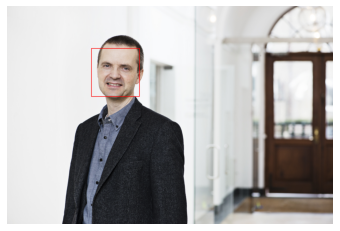

In [22]:
# Extract pre-trained face detector
path_to_face_cascade_str = str(Path.cwd().parent / fc_location)
face_cascade = cv2.CascadeClassifier(path_to_face_cascade_str)

# Convert RGB PIL image to OpenCV image, then to BGR and then to gray scale
cv_img = np.array(pil_img)
cv_bgr = np.flip(cv_img, axis=-1)
cv_gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(cv_gray)
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # and add bounding box to color image
    cv2.rectangle(cv_img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting
# cv_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(cv_img)
plt.axis("off")
plt.show()

### Crop Pictures

Inspiration from [Stackoverflow](https://stackoverflow.com/questions/13211745/detect-face-then-autocrop-pictures)

In [23]:
face_coordinates = tuple(faces[0]) # tuple for first detected face per image (x,y,w,h)
print(face_coordinates)

(457, 229, 260, 260)


#### Crop and resize PIL images

Use image.crop()

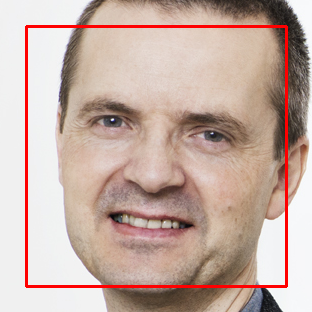

In [24]:
# Crop on PIL

# Convert cv_image to pil_image
face = Image.fromarray(cv_img)

# Convert cv box to PIL box [left, upper, right, lower]
# Calculate scale factors, boxScale values > 1 add some margin outside the box
boxScale=1.1
xDelta=max(face_coordinates[2]*(boxScale-1),0)
yDelta=max(face_coordinates[3]*(boxScale-1),0)

PIL_box=[face_coordinates[0]-xDelta,
         face_coordinates[1]-yDelta,
         face_coordinates[0]+face_coordinates[2]+xDelta,
         face_coordinates[1]+face_coordinates[3]+yDelta
         ]

cropped = face.crop(tuple(PIL_box))
cropped

(128, 128)


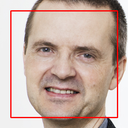

In [25]:
# Make a thumbnail
tn = cropped.copy()
tn.thumbnail((128, 128), Image.ANTIALIAS)
print(tn.size)
tn

#### Crop and resize OpenCV images

Simply use np.slicing (left-to-right as x direction and top-to-bottom as y direction, x,y is top-left)

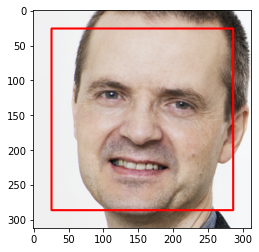

In [26]:
x, y, w, h = face_coordinates

scale_factor = 1.1
x_delta = int(max((scale_factor-1) * w, 0))
y_delta = int(max((scale_factor-1) * h, 0))

cropped = cv_img[y-y_delta:y+y_delta+h, x-x_delta:x+x_delta+w].copy()
plt.imshow(cropped)

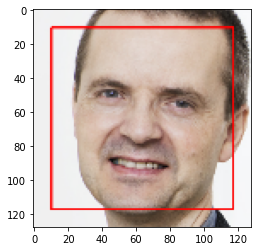

In [27]:
tn = cv2.resize(cropped, dsize=(128, 128))
assert Image.fromarray(tn).size == (128, 128)
plt.imshow(tn)

### Play around with color conversions

Once gray, you don't get your color back (not really surprising ...)

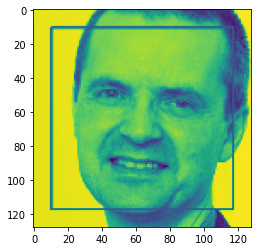

In [170]:
tn_grey = cv2.cvtColor(tn, cv2.COLOR_RGB2GRAY)
plt.imshow(tn_grey)

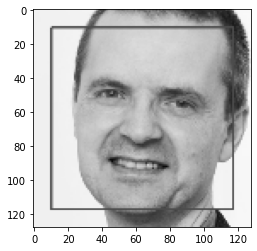

In [172]:
tn_grey2 = cv2.cvtColor(tn_grey, cv2.COLOR_GRAY2RGB)
plt.imshow(tn_grey2)

## Perform some Tests

### Crop multiple faces from a picture

Number of faces detected: 10


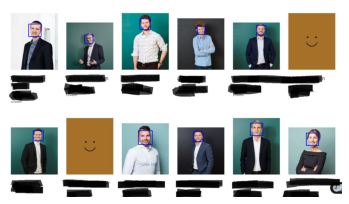

In [30]:
multi_bgr = cv2.imread(str(Path.cwd().parent / "resources/test_image_multi.jpg"))
multi_gray = cv2.cvtColor(multi_bgr, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(multi_gray)
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # and add bounding box to color image
    cv2.rectangle(multi_bgr,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting
multi_rgb = cv2.cvtColor(multi_bgr, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(multi_rgb)
plt.axis("off")
plt.show()

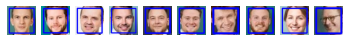

In [32]:
for n, cv_box in enumerate(faces):
    x, y, w, h = cv_box
    x_delta = int(max((scale_factor - 1) * w, 0))
    y_delta = int(max((scale_factor - 1) * h, 0))
    
    face = multi_rgb[
        y - y_delta : y + y_delta + h, x - x_delta : x + x_delta + w
    ].copy()
    
    plt.subplot(1, len(faces), n+1)
    plt.axis('off')
    plt.imshow(face)

### What happens when no face is detected?

In [45]:
path_to_pic = employees['modules'][7]['data']['media']['source']
url_to_image = base_url + path_to_pic
url_to_image

'https://implementconsultinggroup.com//assets/images/employee-default.svg'

In [53]:
r = requests.get(url_to_image)
pil_img = Image.open(BytesIO(r.content))

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000023552CAF6D0>

--> Placeholder images are in svg format and trigger an UnidentifiedImageError when I attempt to load them with PIL / io

In [46]:
multi_bgr = cv2.imread(str(Path.cwd().parent / "resources/test_image_empty.jpg"))
multi_gray = cv2.cvtColor(multi_bgr, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(multi_gray)

In [51]:
print(faces)
print(type(faces))
print(len(faces))

()
<class 'tuple'>
0


In [50]:
faces[0]

IndexError: tuple index out of range

--> If no face is detected in a loaded image, an empty tuple is returned. If I try to get it's first element I will rise and IndexError

---

## Test full pipe

In [175]:
sys.path.append(str(Path.cwd().parent))
from preprocess_img import *

In [176]:
def main(path_to_cfg, N_IMAGES):
    """[summary]
    """
    count_invalid_img = count_no_face_img = count_multi_face_img = 0

    full_url, base_url, path_to_fc, scale_factor, dsize = parse_config_img_data(
        path_to_cfg
    )
    employee_data = scrape_data_from_website(full_url)
    face_cascade = instantiate_OpenCV_face_detector(path_to_fc)

    for i, _ in enumerate(employee_data["modules"][:N_IMAGES]):
        link_to_image = generate_full_link_to_image(i, employee_data, base_url)
        pil_rgb = load_image_PIL(link_to_image)
        if pil_rgb is None:
            count_invalid_img += 1
            continue
        else:
            cv_gray, cv_rgb = convert_image_PIL_to_cv_gray_and_rgb(pil_rgb)
            cv_box, n_faces = detect_face_in_image(cv_gray, face_cascade)
            if n_faces == 0:
                print(f"NO face detected for image nr {i}.")
                count_no_face_img += 1
                continue
            else:
                if n_faces > 1:
                    print(
                        f"More than 1 face detected in image nr {i},",
                        "will use first only.",
                    )
                    count_multi_face_img += 1
                face_rgb = crop_image(cv_rgb, cv_box, scale_factor=1.1)
                face_final = resize_image_cv(face_rgb, dsize)

                plt.subplot(2, int(N_IMAGES/2), i+1)
                plt.axis('off')
                plt.imshow(face_final)

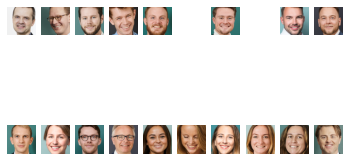

In [177]:
N_IMAGES = 20
path_to_cfg = str(Path.cwd().parent / "config.cfg")

main(path_to_cfg, N_IMAGES)  # 2nd argument for testing only

---